The goal in this notebook will be to clean up the data, especially genre as it's not very useful in its current state.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, label_binarize
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, mean_squared_error, r2_score
import plotly.graph_objects as go
import plotly.express as px
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC


In [2]:
data = pd.read_csv('Data/data.csv', index_col = 'Unnamed: 0')
data.drop('popularity', axis = 1, inplace = True)

### First, further clean the genre column

In [3]:
data['clean_genre'].value_counts()

No Genre                                       13563
['dance pop'                                     389
['adult standards'                               350
['album rock'                                    315
['alternative metal'                             263
['latin'                                         232
['contemporary country'                          196
['alternative rock'                              160
['alternative hip hop'                           135
['bebop'                                         131
['classical performance'                         129
['classic soul'                                  124
['corrido'                                       124
['brill building pop'                            121
['classical'                                     112
['alternative dance'                             107
['atl hip hop'                                   106
['c-pop'                                         105
['alternative country'                        

In [4]:
data['clean_genre'].head(5)

0    ['show tunes']
1          No Genre
2          No Genre
3          No Genre
4          No Genre
Name: clean_genre, dtype: object

In [5]:
#assign groups by searching for key words in existing genres and create a dictionary with the original dataframes index

types = ['hip hop', 'pop', 'rock', 'country', 'classical', 'jazz', 'blues', 'rap', 'folk', 'trance', 'edm','No Genre','soul', 'metal','funk','indie', 'broadway']

grouped = dict()
for t in types:
    for i,row in enumerate(data['clean_genre']):
        if t in row:
            grouped.update({i:t})

In [6]:
dict_genre = data['clean_genre'].to_dict()

In [7]:
def combine_dict(d1, d2):
    combined = {}
    for k in set(d1.keys()) | set(d2.keys()):
        combined[k] = tuple(d[k] for d in [d1, d2] if k in d)
    return combined

combined = combine_dict(dict_genre, grouped)

In [8]:
len(grouped)

23570

In [9]:
combined_df = pd.DataFrame.from_dict(combined, orient = 'index', columns = ['first', 'second'])
data['new_genre'] = combined_df['second']

In [10]:
#add the new, grouped genre to the dataframe

data['new_genre'].fillna('No Genre', inplace = True)

In [11]:
print(data['new_genre'].value_counts())
print(data.shape)

No Genre     22532
pop           2333
rock          1386
classical      952
hip hop        694
rap            683
country        636
indie          509
metal          490
jazz           459
folk           407
trance         382
blues          308
soul           303
funk           254
broadway       111
edm            100
Name: new_genre, dtype: int64
(32539, 18)


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32539 entries, 0 to 32538
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   artists            32539 non-null  object 
 1   acousticness       32539 non-null  float64
 2   danceability       32539 non-null  float64
 3   duration_ms        32539 non-null  float64
 4   energy             32539 non-null  float64
 5   instrumentalness   32539 non-null  float64
 6   liveness           32539 non-null  float64
 7   loudness           32539 non-null  float64
 8   speechiness        32539 non-null  float64
 9   tempo              32539 non-null  float64
 10  valence            32539 non-null  float64
 11  key                32539 non-null  int64  
 12  mode               32539 non-null  int64  
 13  count              32539 non-null  int64  
 14  popularity_labels  32539 non-null  object 
 15  clean_genre        32539 non-null  object 
 16  energy_loudness    325

In [13]:
#dummy genre

ddata = pd.get_dummies(data, columns = ['new_genre'], drop_first = True)

In [14]:
#add interaction
energy_interaction = ddata['energy'] * ddata['loudness']
ddata['energy_loudness'] = energy_interaction

In [15]:
ddata['popularity_labels'].replace(to_replace = 'Very Successful', value = '3', inplace = True)
ddata['popularity_labels'].replace(to_replace = 'Successful', value = '2', inplace = True)
ddata['popularity_labels'].replace(to_replace = 'Unsuccessful', value = '1', inplace = True)

ddata['popularity_labels'].astype('int64')

0        2
1        2
2        2
3        2
4        2
5        2
6        1
7        1
8        2
9        1
10       3
11       3
12       1
13       3
14       3
15       3
16       2
17       3
18       2
19       1
20       3
21       3
22       3
23       1
24       3
25       1
26       2
27       1
28       1
29       1
30       3
31       3
32       3
33       3
34       2
35       2
36       3
37       1
38       1
39       2
40       2
41       3
42       1
43       1
44       3
45       2
46       1
47       1
48       1
49       1
50       1
51       1
52       1
53       1
54       3
55       2
56       1
57       3
58       3
59       1
60       3
61       2
62       2
63       2
64       3
65       3
66       2
67       1
68       3
69       2
70       1
71       1
72       1
73       1
74       1
75       1
76       1
77       2
78       1
79       1
80       1
81       1
82       1
83       1
84       1
85       1
86       1
87       1
88       1
89       1
90       1

In [16]:
X = ddata.drop(columns = ['popularity_labels','artists','clean_genre'], axis = 1)
y= ddata['popularity_labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42, stratify = y)

In [17]:
ss = StandardScaler()

ss_X_train = ss.fit_transform(X_train)
ss_X_test = ss.transform(X_test)

### Fit the next iteration of Logistic Regression with the new genre features

In [18]:
X.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,new_genre_funk,new_genre_hip hop,new_genre_indie,new_genre_jazz,new_genre_metal,new_genre_pop,new_genre_rap,new_genre_rock,new_genre_soul,new_genre_trance
0,0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,...,0,0,0,0,0,0,0,0,0,0
1,0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,...,0,0,0,0,0,0,0,0,0,0
2,0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,...,0,0,0,0,0,0,0,0,0,0
3,0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,...,0,0,0,0,0,0,0,0,0,0
4,0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32539 entries, 0 to 32538
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   acousticness         32539 non-null  float64
 1   danceability         32539 non-null  float64
 2   duration_ms          32539 non-null  float64
 3   energy               32539 non-null  float64
 4   instrumentalness     32539 non-null  float64
 5   liveness             32539 non-null  float64
 6   loudness             32539 non-null  float64
 7   speechiness          32539 non-null  float64
 8   tempo                32539 non-null  float64
 9   valence              32539 non-null  float64
 10  key                  32539 non-null  int64  
 11  mode                 32539 non-null  int64  
 12  count                32539 non-null  int64  
 13  energy_loudness      32539 non-null  float64
 14  new_genre_blues      32539 non-null  uint8  
 15  new_genre_broadway   32539 non-null 

Recall Score: 0.566
Precision Score: 0.622
Accuracy Score: 0.645


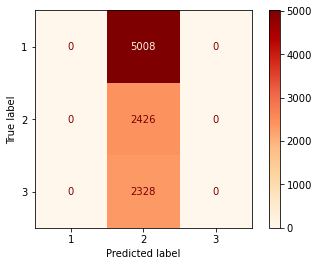

In [26]:
log_reg = LogisticRegression(max_iter = 700)

#fit and predict
log_reg.fit(ss_X_train, y_train)
y_hat = log_reg.predict(ss_X_test)

cmv = plot_confusion_matrix

cmv(log_reg, X_test, y_test, cmap = 'OrRd');
print('Recall Score: {}'.format(recall_score(y_test, y_hat, average = 'macro').round(3)))
print('Precision Score: {}'.format(precision_score(y_test, y_hat, average = 'macro').round(3)))
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_hat).round(3)))

Disappointing results with only a slightly better score than the original model. The majority class is still performing much better than the other two. 

In [21]:
r2 = r2_score(y_test, y_hat)
rmse = mean_squared_error(y_test, y_hat, squared=False)

#print('R2 Score: {}'.format(r2))
#print('MSE: {}'.format(rmse))

Again, disappointing results. Recall has even slightly reduced, which is concerning considering I'd rather have a higher recall score than precision. 
These restuls make me confident that the null hypothesis is true and these features have little impact on the popularity and success of a song.

### In one last effort to improve this model, we'll try a GridSearch

In [22]:
pipe = Pipeline([('classifier' , LogisticRegression())])


param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['sag', 'saga'],
    'classifier__multi_class' : ['multinomial', 'ovr']}]

In [23]:
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(ss_X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.2s


KeyboardInterrupt: 

In [ ]:
best_clf.best_params_

Recall Score: 0.566
Precision Score: 0.622
Accuracy Score: 0.645


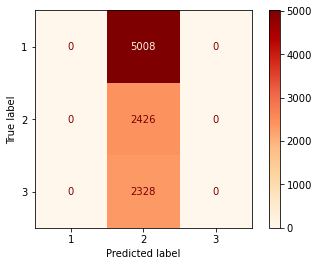

In [25]:
log_reg = LogisticRegression(solver='saga', penalty = 'l1', C = 1.6, max_iter = 700)

#fit and predict
log_reg.fit(ss_X_train, y_train)
y_hat = log_reg.predict(ss_X_test)

cmv = plot_confusion_matrix

cmv(log_reg, X_test, y_test, cmap = 'OrRd');
print('Recall Score: {}'.format(recall_score(y_test, y_hat, average = 'macro').round(3)))
print('Precision Score: {}'.format(precision_score(y_test, y_hat, average = 'macro').round(3)))
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_hat).round(3)))

In [ ]:
r2 = r2_score(y_test, y_hat)
rmse = mean_squared_error(y_test, y_hat, squared=False)

print('R2 Score: {}'.format(r2))
print('MSE: {}'.format(rmse))

Okay, well these parameters suggested by GridSearch have slightly decreased the model performance

It's very obvious at this point that the imbalanced nature of this data is impacting results. Because the data isn't heavily imbalanced, I had assumed SMOTE or a different technique was unneccesary, but am now reconsidering.  Maybe with some tuning we can get a better result. 

In [28]:
ddata.to_csv('Data/cleaned_data.csv')